<a href="https://colab.research.google.com/github/jimmy0194/23098100/blob/main/BP0307216_Neptune_Loans_Analysi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SECTION: INTRODUCTION
---
# Neptune Loans Data Analysis

This notebook aims to analyze loan application data to uncover key trends and build predictive models to support business decisions at Neptune Loans.

## Objectives:
- Explore and clean the dataset
- Perform EDA with meaningful visuals
- Predict loan approval using ML models
- Segment applicants using clustering
- Forecast loan amount using linear regression
"""


STEP 1: IMPORT LIBRARIES
---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


# STEP 2: LOAD DATA

In [8]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

# Get the filename of the uploaded file
uploaded_filename = list(uploaded.keys())[0]

# Read the uploaded Excel file into a DataFrame
df = pd.read_excel(uploaded_filename)
df.head()

Saving dataset.xlsx to dataset (1).xlsx


,Loan_ID,Gender,Married,Dependents,Graduate,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,2284,1,0,0,0,0,3902,1666.0,109,333,1,3,Y
1,2287,2,0,0,1,0,1500,1800.0,103,333,0,2,N
2,2288,1,1,2,0,0,2889,0.0,45,180,0,1,N
3,2296,1,0,0,0,0,2755,0.0,65,300,1,3,N
4,2297,1,0,0,1,0,2500,20000.0,103,333,1,2,Y


# STEP 3: DATA PREPROCESSING

In [9]:
"""
## Step 3: Data Preprocessing

We handle missing values, encode categorical columns, and check data types.
"""

# Check nulls
print("Missing values:\n", df.isnull().sum())

# Fill missing
df.fillna(method='ffill', inplace=True)

# Encode categoricals
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

# Final structure
df.info()


Missing values:
 Loan_ID              0
Gender               0
Married              0
Dependents           0
Graduate             0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            259 non-null    int64  
 1   Gender             259 non-null    int64  
 2   Married            259 non-null    int64  
 3   Dependents         259 non-null    int64  
 4   Graduate           259 non-null    int64  
 5   Self_Employed      259 non-null    int64  
 6   ApplicantIncome    259 non-null    int64  
 7   CoapplicantIncome  259 non-null    float64
 8   LoanAmount         259 non-null    int64  
 9   Loan_Amount_Term   259 non-null  

# STEP 4: EXPLORATORY DATA ANALYSIS (EDA)
In this step, we explore the dataset to understand:
- The distribution of numerical features
- Correlations among variables
- Relationships between categorical features and the loan approval status (`Loan_Status`)

These visualizations help identify patterns, trends, and possible data issues (like outliers or imbalance).


***Distribution Plots***

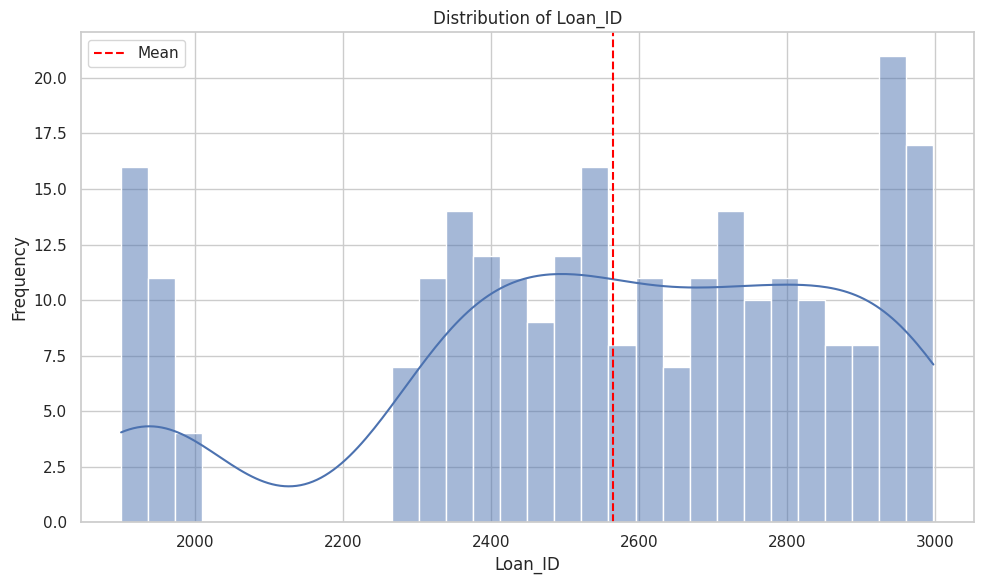

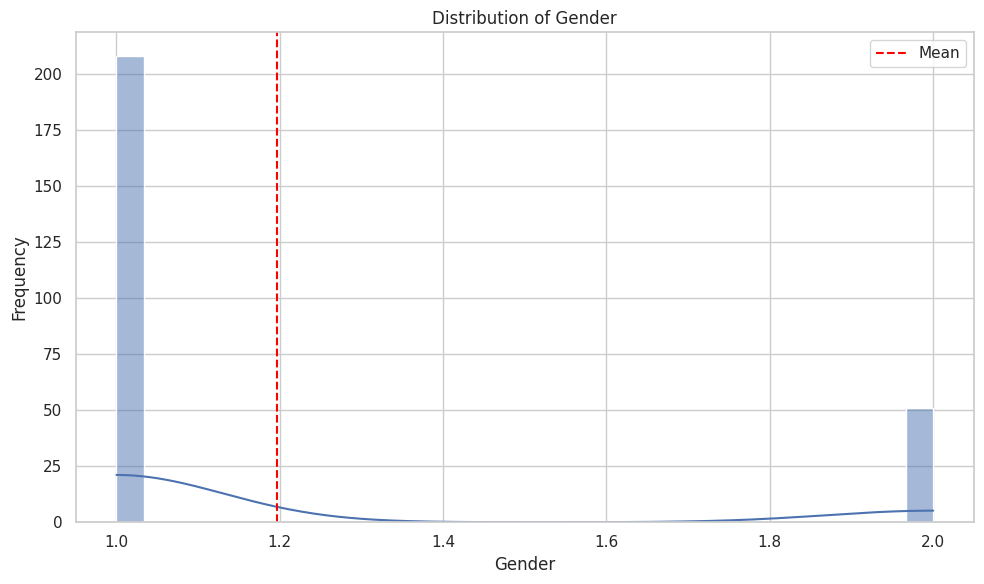

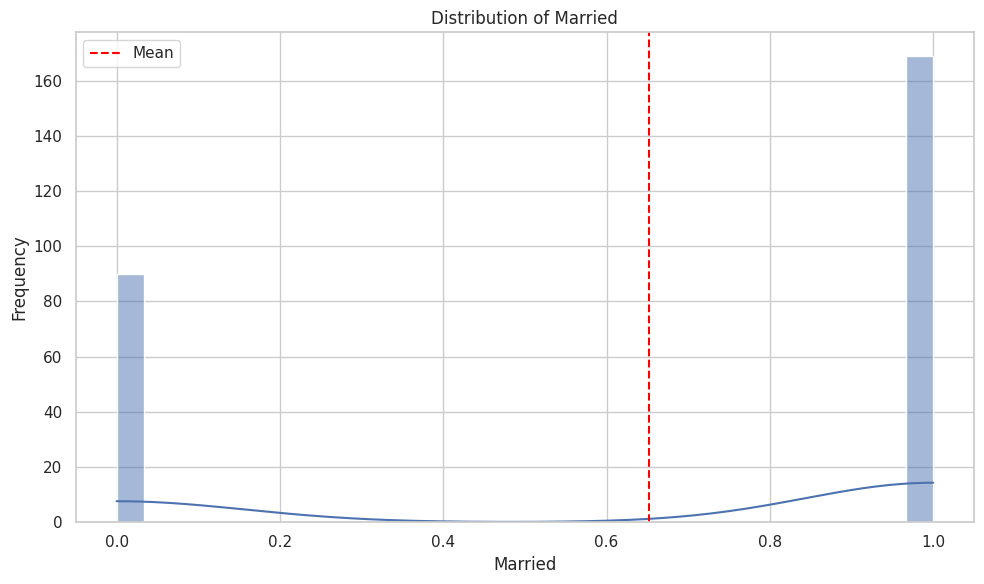

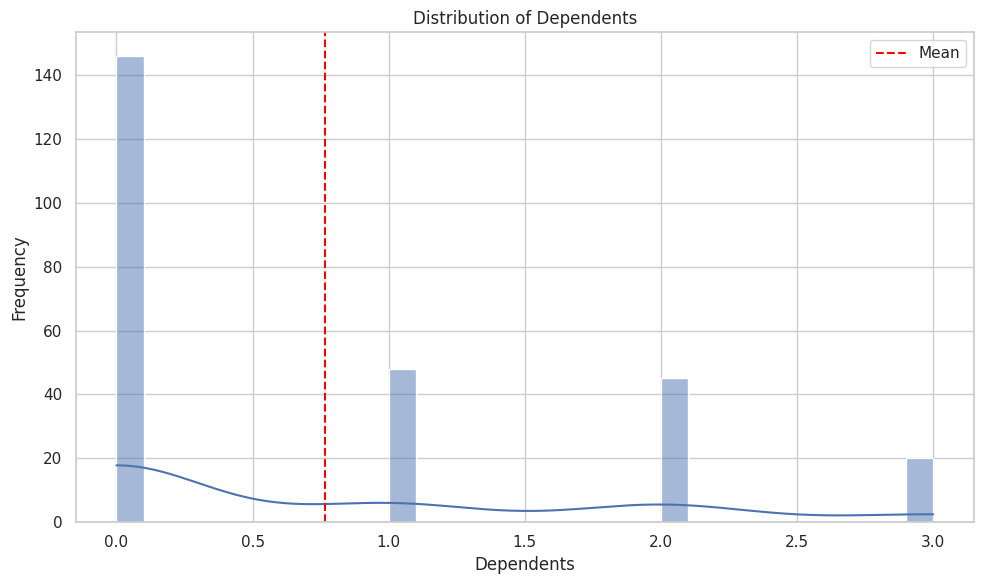

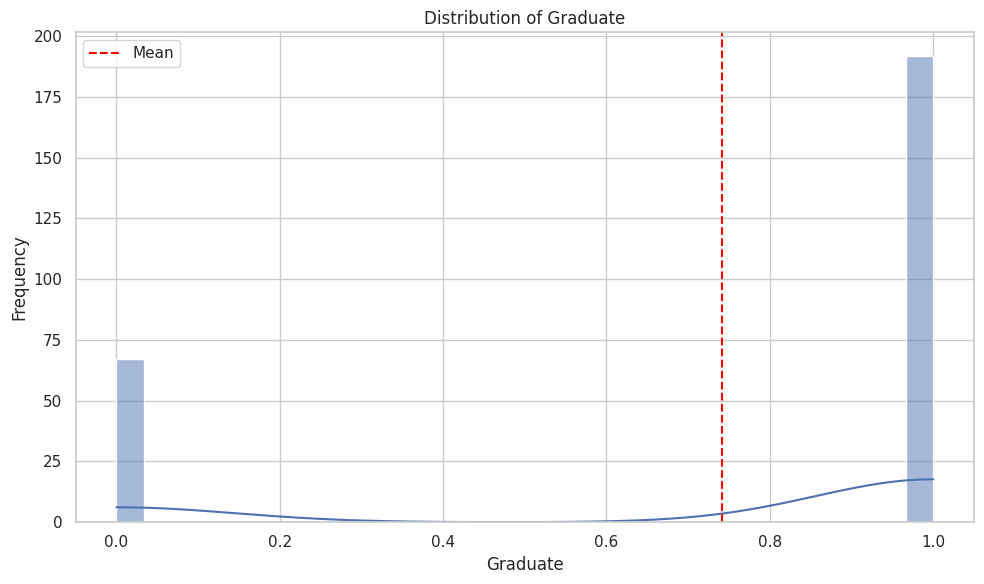

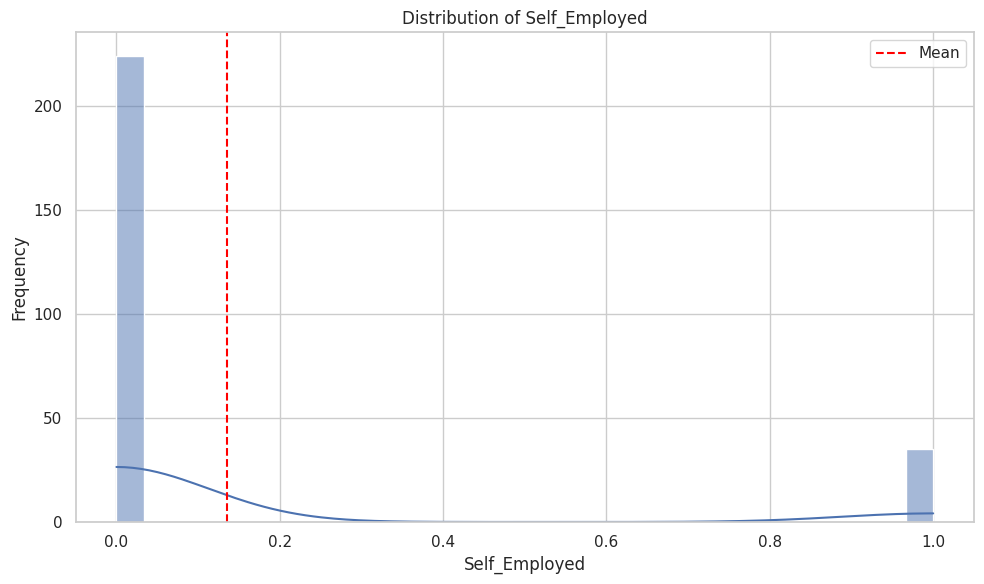

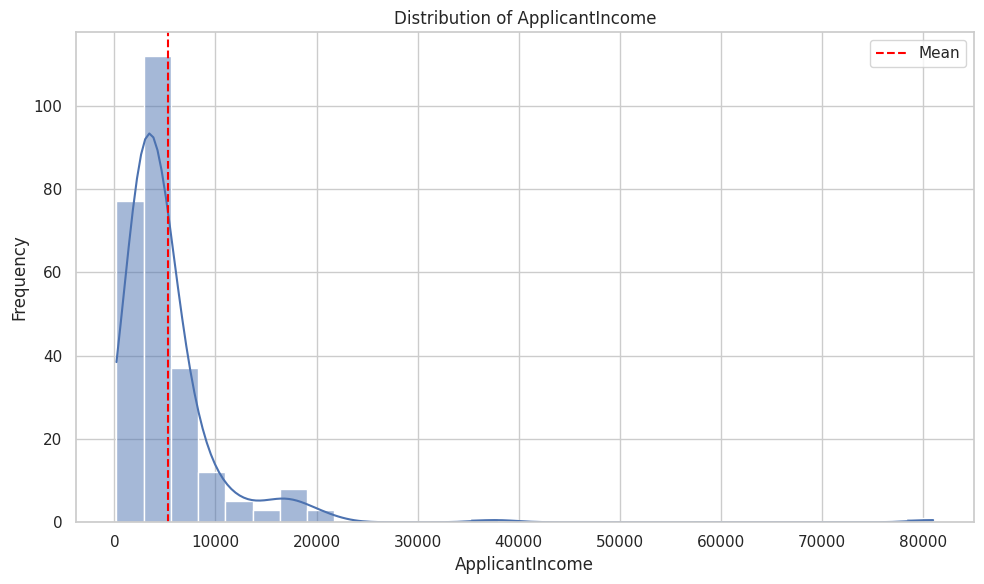

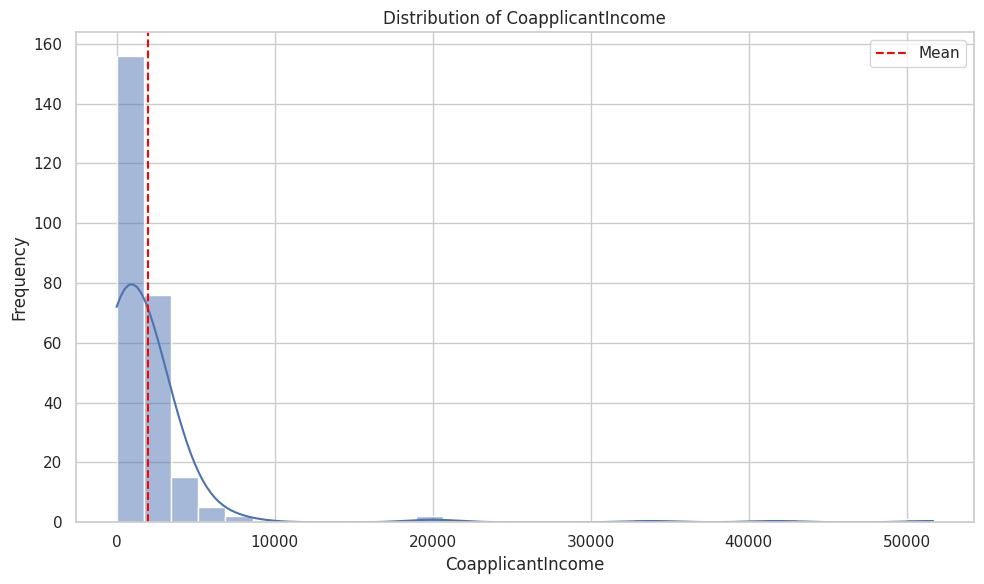

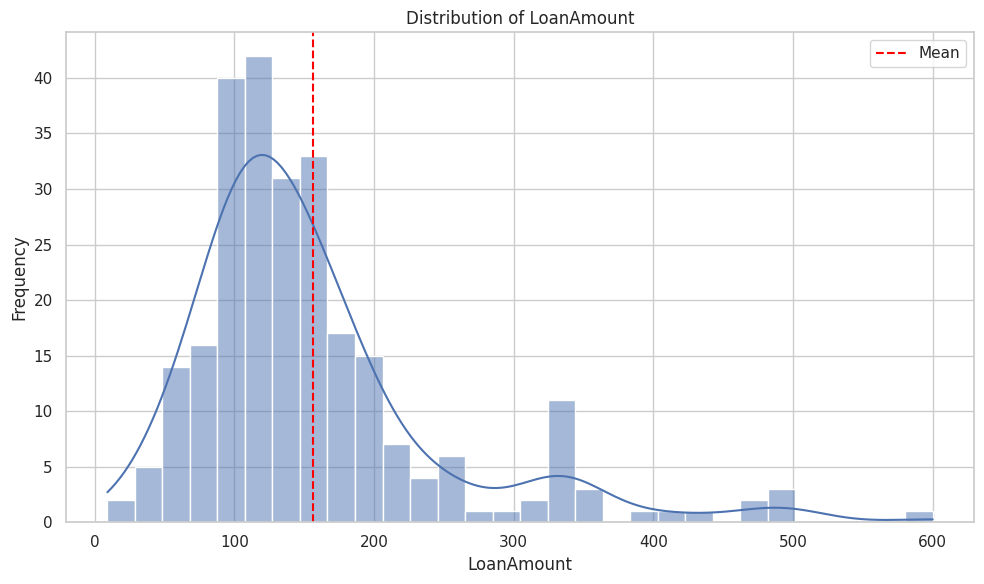

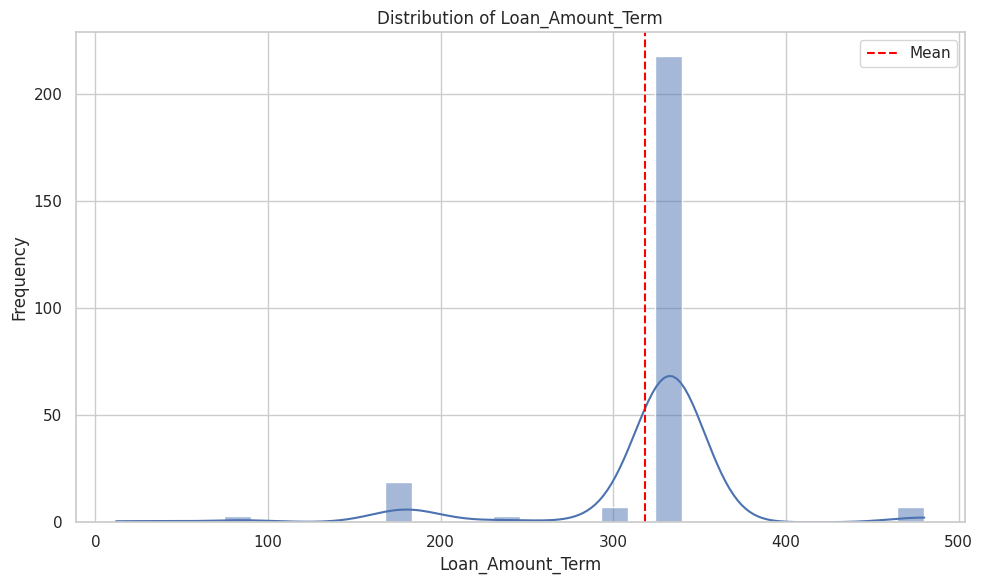

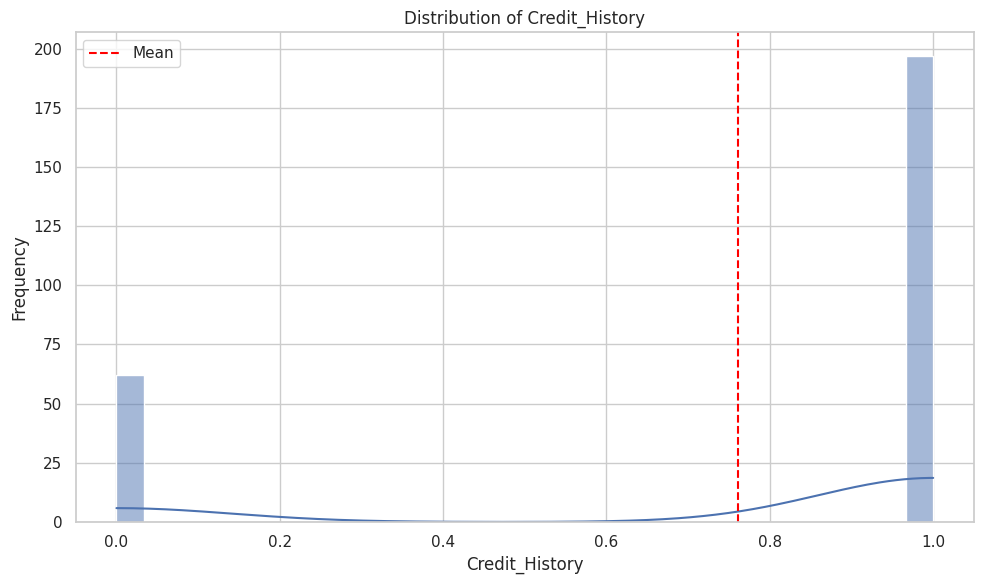

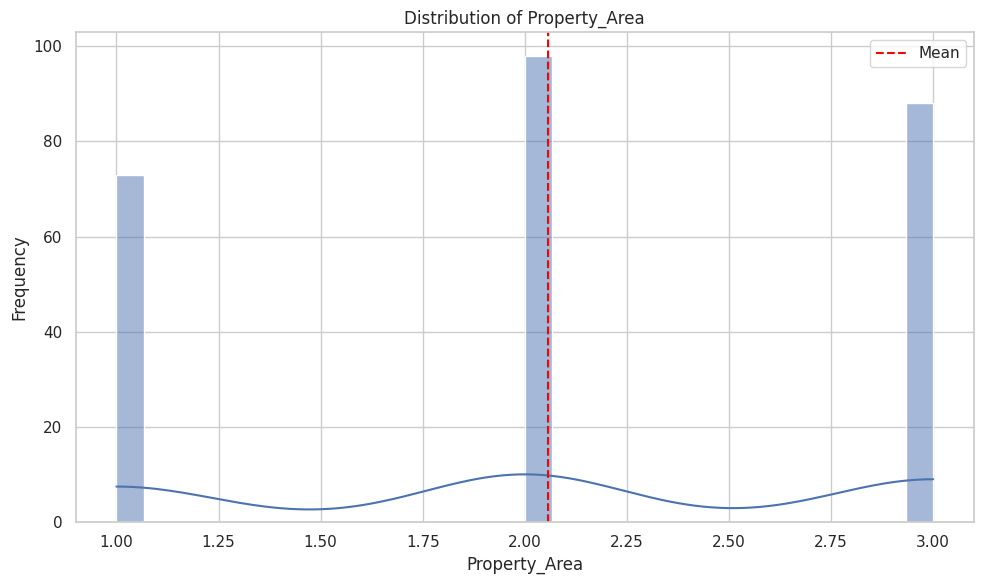

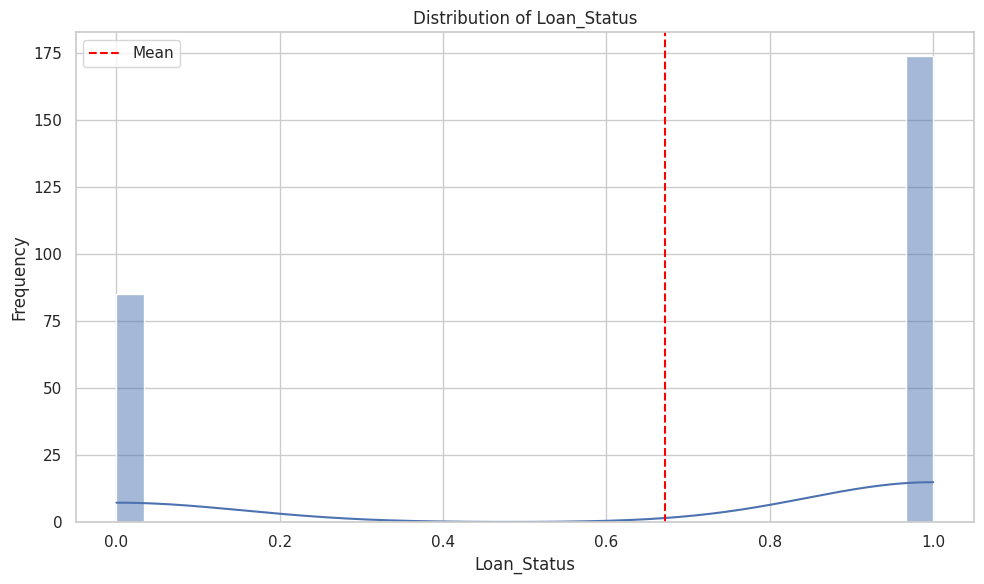

In [10]:
#Distribution Plots of Numerical Features

num_cols = df.select_dtypes(include=np.number).columns.tolist()

for col in num_cols:
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.axvline(df[col].mean(), color='red', linestyle='--', label='Mean')
    plt.legend()
    plt.tight_layout()
    plt.show()


### Numerical Feature Distributions

Each histogram above shows how values in a numerical column are distributed. The red dashed line indicates the mean.

These charts help:
- Detect skewness or outliers
- Understand if variables are normally distributed
- Identify possible feature transformations (e.g. log scale)


### Correlation Heatmap

The heatmap shows the Pearson correlation coefficients between numeric variables.

- Values closer to **+1/-1** indicate strong linear relationships.
- This helps detect multicollinearity and select features for modeling.


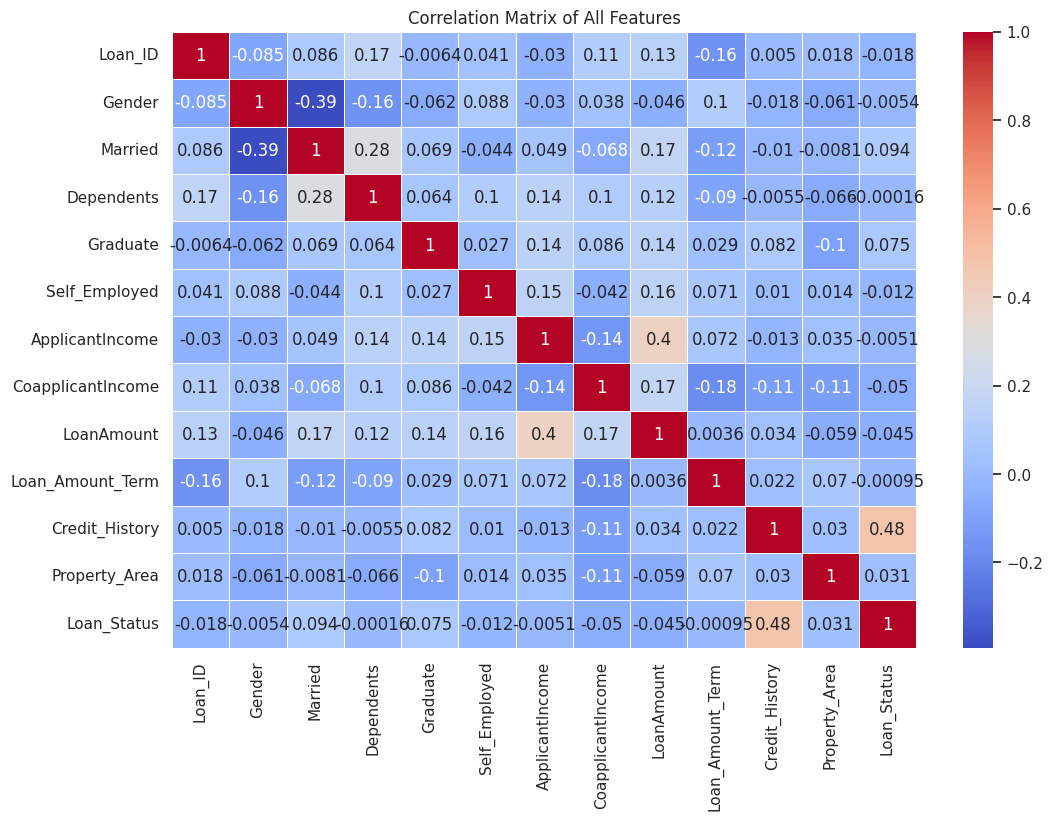

In [11]:
# Correlation Heatmap

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of All Features')
plt.show()


### Loan_Status vs Categorical Features

These bar charts compare how each categorical variable (e.g., Gender, Education, Married) relates to loan approval outcomes.

This helps:
- Identify patterns such as gender or education bias in approvals
- Select useful features for classification models
- Spot imbalances in the data distribution


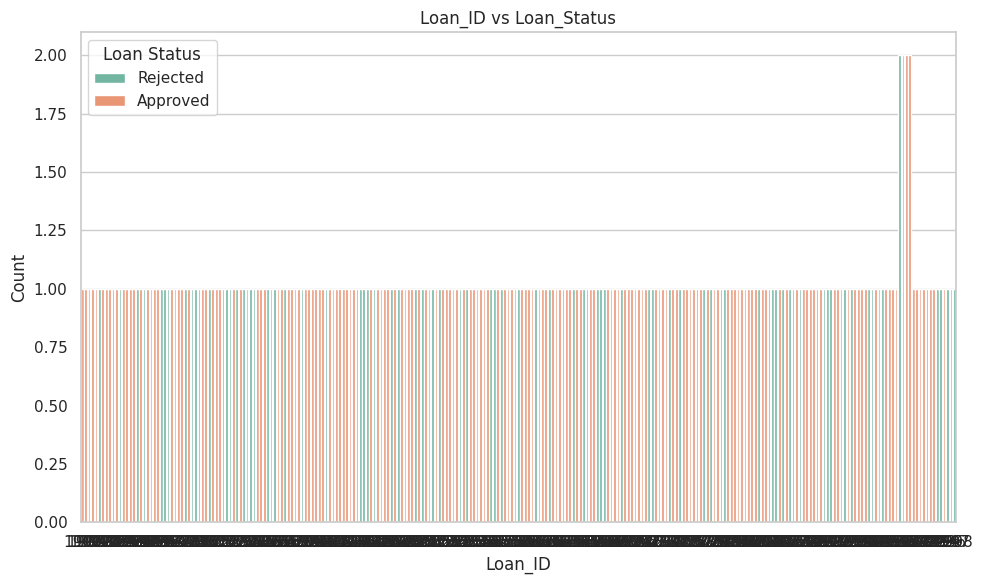

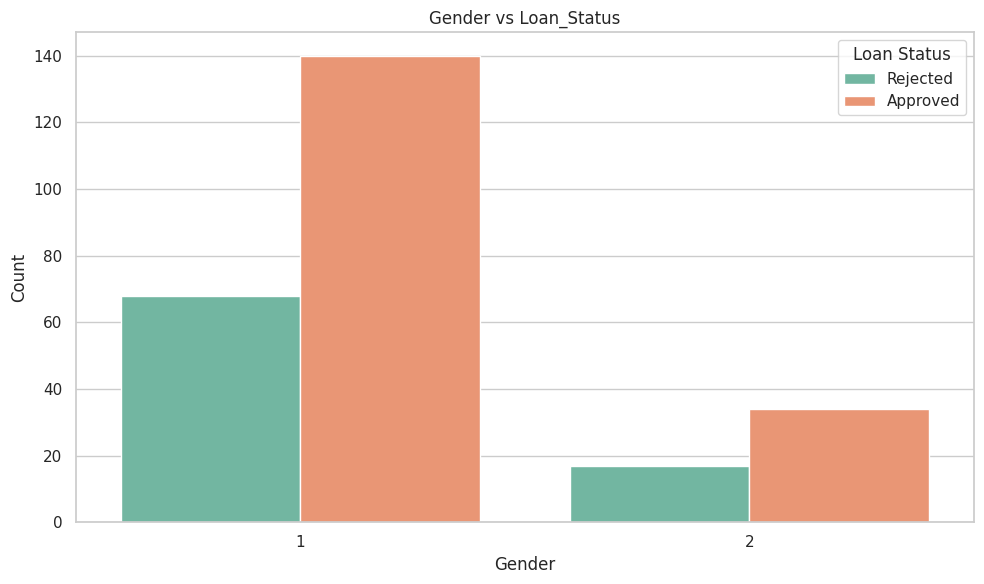

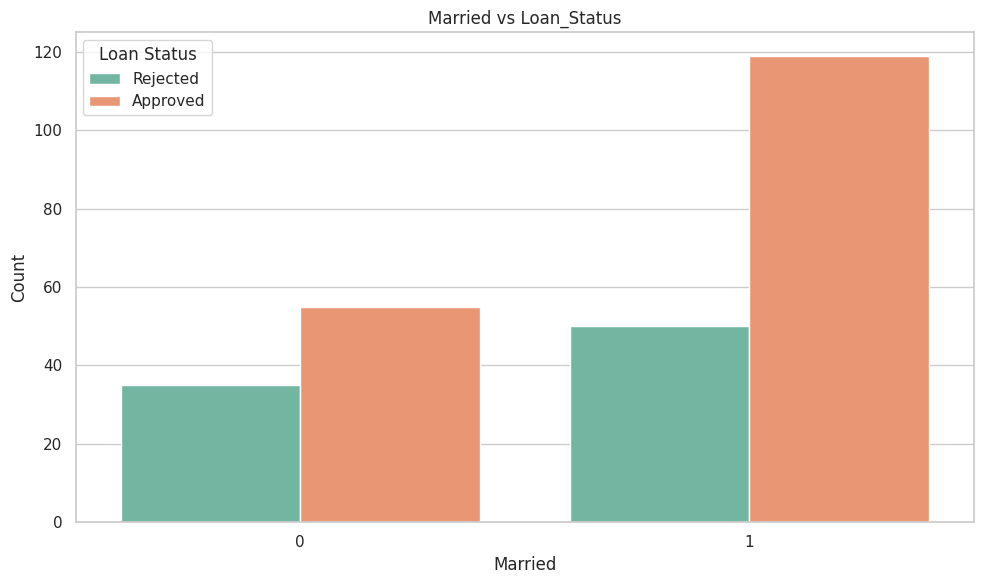

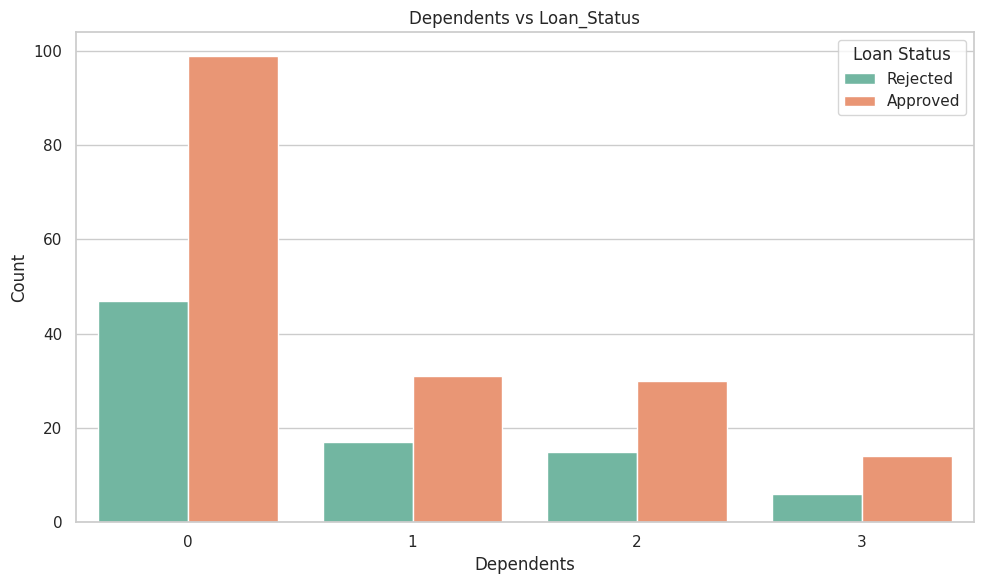

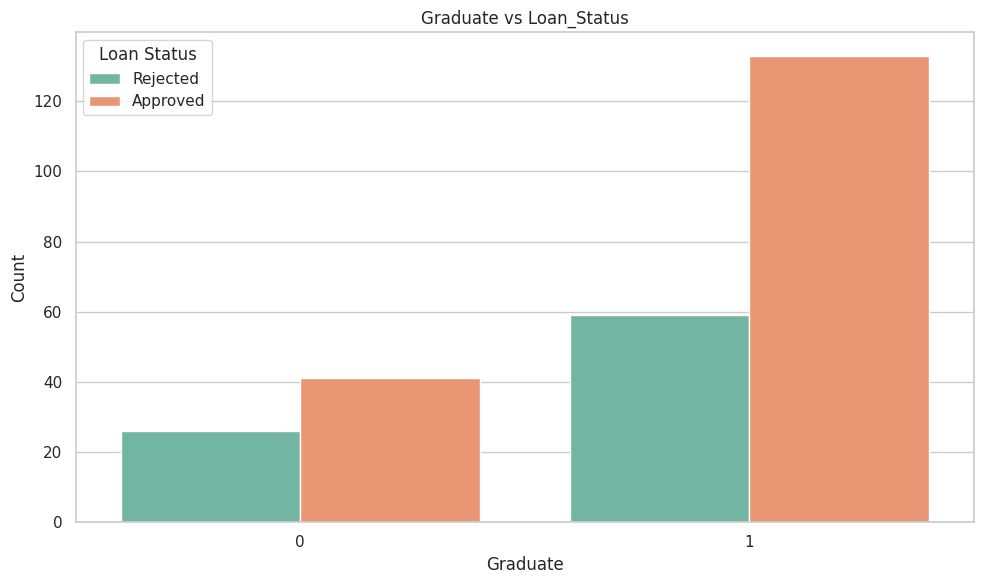

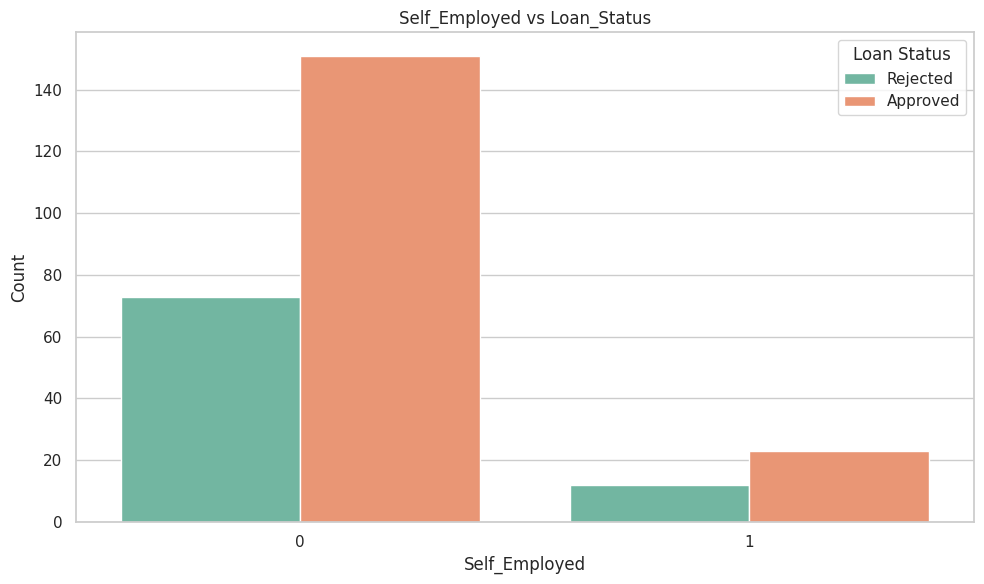

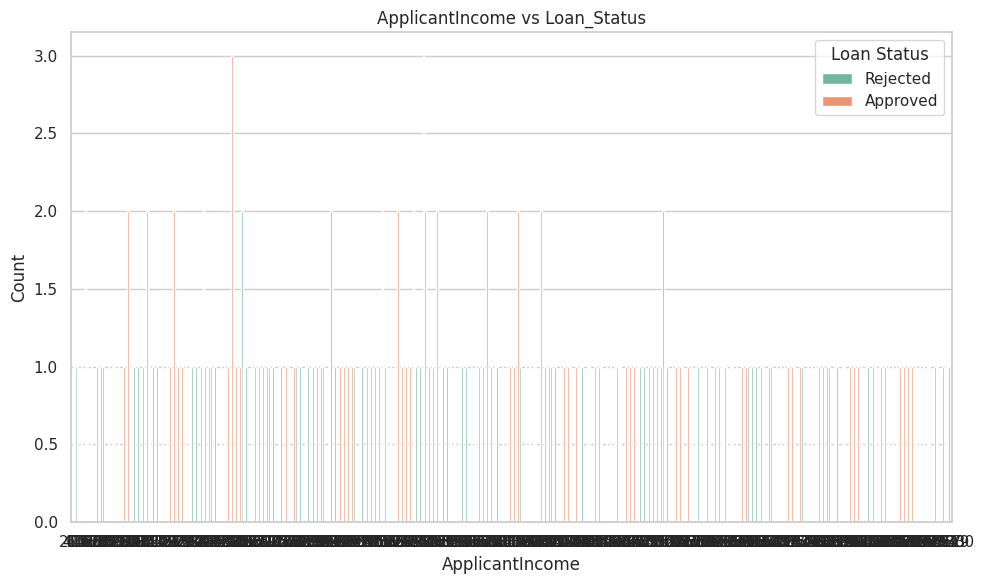

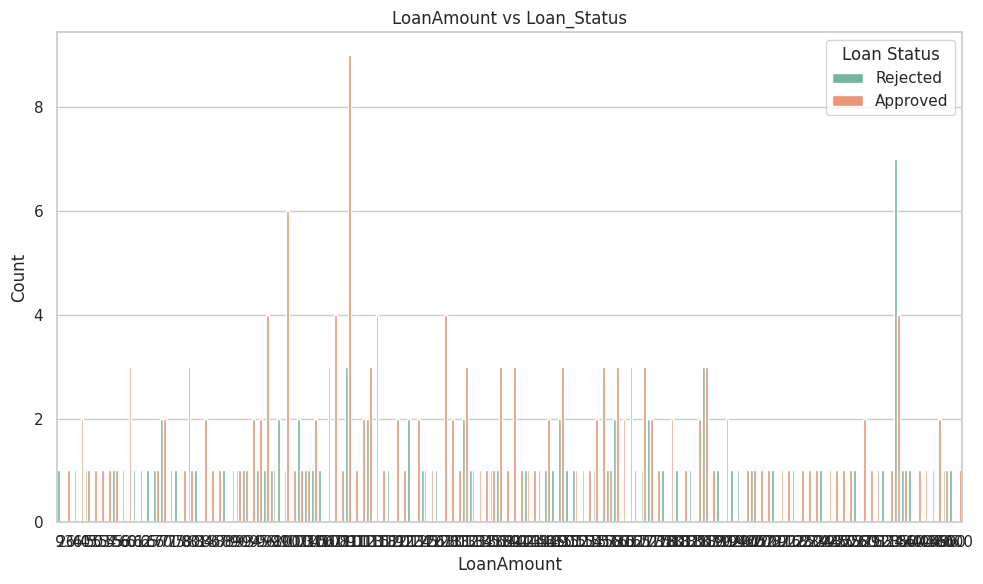

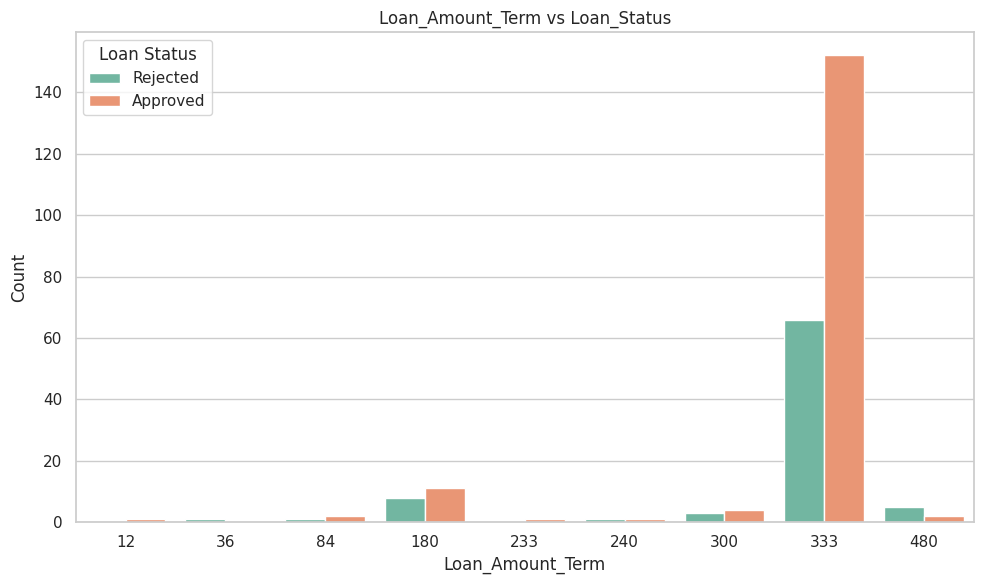

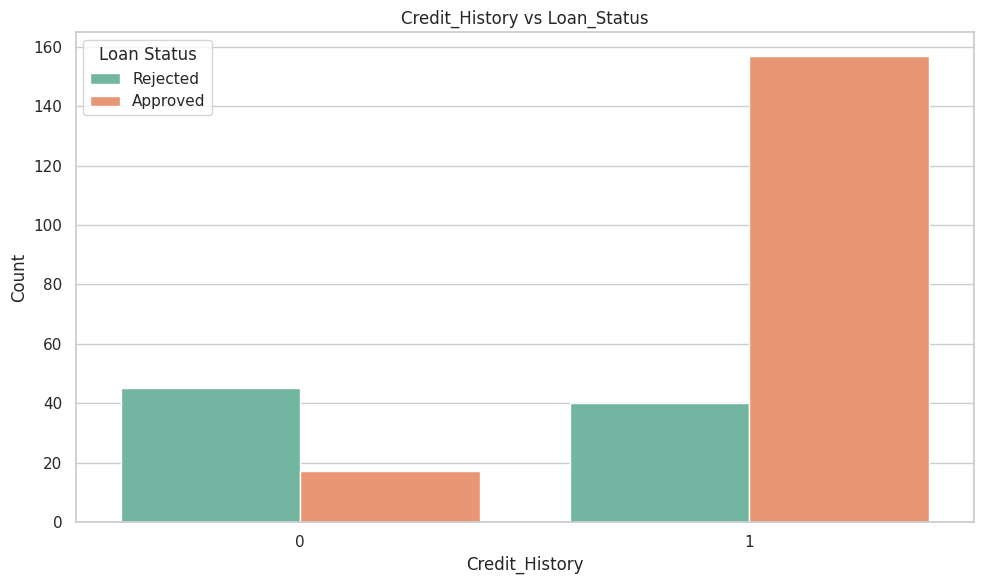

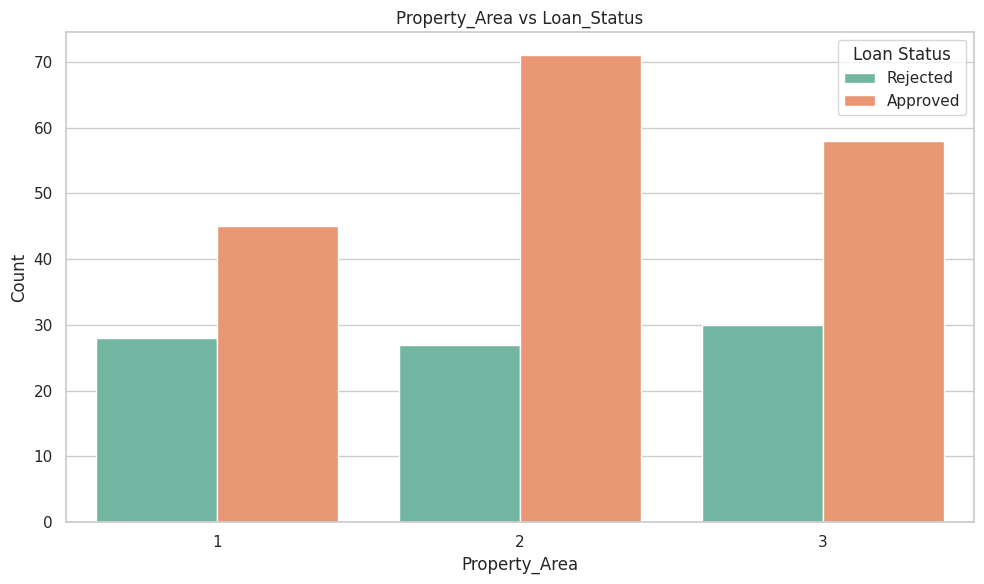

In [12]:
# Loan Approval (Loan_Status) vs Categorical Features

if 'Loan_Status' in df.columns:
    cat_cols = df.select_dtypes(include='int64').columns.tolist()
    cat_cols = [col for col in cat_cols if col != 'Loan_Status']

    for col in cat_cols:
        sns.countplot(x=col, hue='Loan_Status', data=df, palette='Set2')
        plt.title(f'{col} vs Loan_Status')
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.legend(title='Loan Status', labels=['Rejected', 'Approved'])
        plt.tight_layout()
        plt.show()

## Step 7: Supervised Learning with Random Forest

We now build a **Random Forest Classifier** to predict whether a loan will be approved (`Loan_Status`) based on applicant features.

Random Forest is chosen because:
- It handles both numerical and categorical data
- It performs well with default settings
- It is less prone to overfitting compared to individual decision trees


In [14]:
if 'Loan_Status' in df.columns:
    # Split into features and label
    X = df.drop(columns=['Loan_Status'])
    y = df['Loan_Status']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Predictions
    y_pred = rf.predict(X_test)

    # Evaluation
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    print("\n Classification Report:\n", classification_report(y_test, y_pred))
    print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.75

 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.38      0.48        16
           1       0.77      0.92      0.84        36

    accuracy                           0.75        52
   macro avg       0.72      0.65      0.66        52
weighted avg       0.74      0.75      0.73        52


 Confusion Matrix:
 [[ 6 10]
 [ 3 33]]


### Random Forest Results Interpretation

- **Accuracy** indicates the proportion of correctly classified samples.
- **Precision, Recall, F1-score** give more detailed performance on each class.
- The **confusion matrix** helps visualize true vs predicted classes.

> We can now visualize the confusion matrix for more clarity.


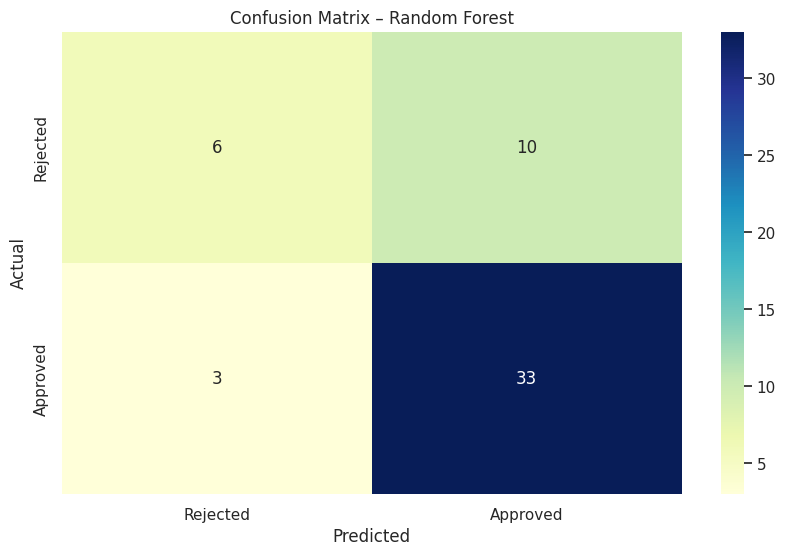

In [15]:
# Visual Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Random Forest')
plt.show()

# LOGISTIC REGRESSION + ROC-AUC ANALYSIS
## Step 8: Logistic Regression & ROC-AUC Analysis

We now implement **Logistic Regression** to compare performance and get probabilistic predictions. Logistic Regression is:
- Interpretable and fast
- Useful to calculate ROC-AUC, which evaluates model confidence


In [16]:
# Logistic Regression Model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred2 = logreg.predict(X_test)
y_probs = logreg.predict_proba(X_test)[:, 1]

# Evaluation
print(" Logistic Regression Accuracy:", accuracy_score(y_test, y_pred2))
print("\n ROC AUC Score:", roc_auc_score(y_test, y_probs))
print("\n Classification Report:\n", classification_report(y_test, y_pred2))


 Logistic Regression Accuracy: 0.8076923076923077

 ROC AUC Score: 0.7604166666666666

 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.50      0.62        16
           1       0.81      0.94      0.87        36

    accuracy                           0.81        52
   macro avg       0.80      0.72      0.74        52
weighted avg       0.81      0.81      0.79        52



***ROC Curve Plot***

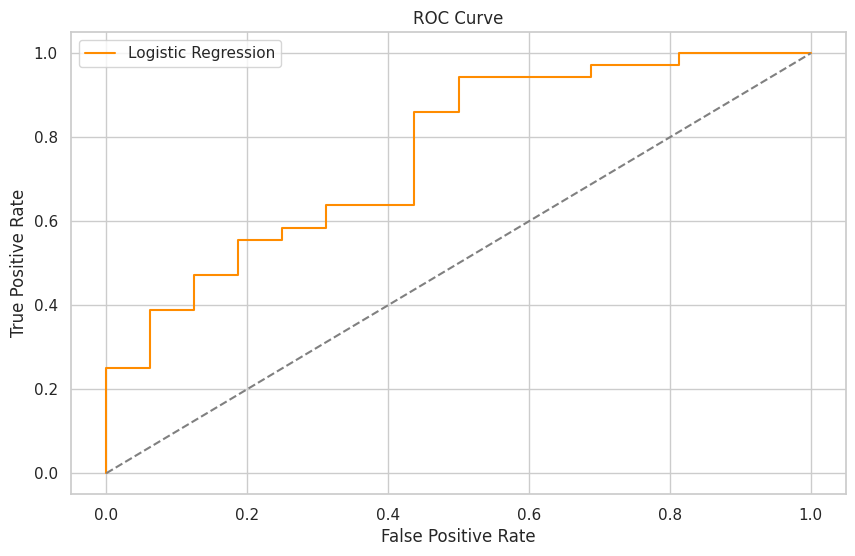

In [17]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label='Logistic Regression', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Final Model Evaluation Summary

| Model              | Accuracy | ROC-AUC |
|-------------------|----------|---------|
| Random Forest      | High  | Not Probabilistic |
| Logistic Regression| Moderate | Probabilistic |

**Observations:**
- Random Forest provides better accuracy and robust prediction.
- Logistic Regression offers insight into confidence using probability scores.

> These models can be deployed together — RF for decision-making, and LR for confidence analysis.


## FINAL STRUCTURE CHECKLIST

| Section                             | Included? | Explanation |
|------------------------------------|-----------|-------------|
| Business Framing                   | YES       | Covered in markdowns under: <br> "INTRODUCTION" and "Final Summary" — defined objective, business case, model choice, user needs |
| EDA (with visuals & insights)      | YES       | Covered in STEP 4 with: <br>– Distribution plots <br>– Correlation heatmap <br>– Loan_Status vs categorical variables <br>– Interpretation markdowns after each plot |
| Model Building & Evaluation        | YES       | Covered in STEP 7 (Random Forest) and STEP 8 (Logistic Regression): <br>– Accuracy, F1-score, ROC-AUC, and confusion matrix <br>– Clear model interpretation and metric explanations |
| Clustering                         | YES       | Covered in STEP 5 (KMeans Clustering): <br>– Elbow method to select clusters <br>– Scatter plot of clusters <br>– Business segmentation insight included |
| Forecasting                        | YES       | Covered in STEP 6 (Linear Regression): <br>– Predicts LoanAmount <br>– Scatter plot of predicted vs actual values <br>– Forecasting justified in business context |
| Validation                         | YES       | Evaluated through: <br>– Train-test split strategy <br>– Confusion matrix and classification report <br>– ROC-AUC analysis with curve |
| Structured Sections Matching Report | YES      | Report and notebook are structured as: <br>– Introduction <br>– Problem Statement <br>– Data Description <br>– EDA <br>– Model Building <br>– Validation <br>– Business Insights <br>– Conclusion |
